In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.util as util
import itertools
from scipy import stats
import os
from scripts.seed_corr import import_ts, correlate_ts, get_conn, get_data, select_regions
import pingouin as pg
from copy import deepcopy
from paths import set_base_dir




# Study demographics
## Full Sample

In [2]:
# import demographic data
base_dir = set_base_dir()

info = pd.read_csv(
    f'{base_dir}/participants.tsv', sep='\t')

In [3]:
demographics = info.groupby(['group']).agg({'sex': pd.Series.value_counts,
                                               'age': ['mean', 'std', 'min', 'max'],
                                               'condition': pd.Series.value_counts})
demographics.to_latex(f'{base_dir}/results/demographics.tex')

# Print out the unique levels of each categorical variable
sex_levels = info['sex'].unique()
group_levels = info['group'].unique()
condition_levels = info['condition'].unique()
print("Sex levels:", sex_levels)
print("Group levels:", group_levels)
print("Condition levels:", condition_levels)
demographics

Sex levels: ['m' 'f']
Group levels: ['p' 'c']
Condition levels: ['PropFB' 'VMFB' 'VM' 'Prop']


sex     age                            condition
      value_counts    mean        std min max      value_counts
group                                                          
c         [20, 20]  55.800  10.830157  24  70  [10, 10, 10, 10]
p         [21, 19]  55.325  11.289631  18  76  [10, 10, 10, 10]

## Template generation sample and validation sample

In [31]:
# import list of subjects that are included in the template
template_sample = pd.read_csv(
    f'{base_dir}/../code/cerebellar_degeneration/data/template_degeneration_40_subjects.tsv', sep=',')
included_subject_list = template_sample.subject.tolist()


In [32]:
# add information on whether subject was included in the template to the participant template_demographics
info['template_included'] = [subject in included_subject_list for subject in info.participant_id.tolist()]
# add information on which scan (pre or post) was used for the template
info['template_timepoint'] = None
for s,subject in enumerate(info.participant_id):
    if subject in included_subject_list:
        info.at[s,'template_timepoint'] = template_sample[template_sample.subject == subject].session.values[0].split('-')[1]


In [33]:
# Show template_demographics of included and excluded subjects (count categorical values of sex, group and condition and calculate mean and std of age)
template_demographics = info.groupby(['template_included']).agg({'sex': pd.Series.value_counts,
                                               'age': ['mean', 'std'],
                                               'group': pd.Series.value_counts,
                                               'condition': pd.Series.value_counts,
                                               'template_timepoint': pd.Series.value_counts})
template_demographics = template_demographics.reindex([True, False])
template_demographics.to_latex(f'{base_dir}/results/template_demographics.tex')

# Print the levels of the categorical variables
timepoint_levels = info['template_timepoint'].unique()
print("Sex levels:", sex_levels)
print("Group levels:", group_levels)
print("Condition levels:", condition_levels)
print("Timepoint levels:", timepoint_levels)

template_demographics



Sex levels: ['m' 'f']
Group levels: ['p' 'c']
Condition levels: ['PropFB' 'VMFB' 'VM' 'Prop']
Timepoint levels: ['pre' None 'post']


sex     age                   group  \
                  value_counts    mean        std value_counts   
template_included                                                
True                  [23, 17]  57.150   9.962880     [20, 20]   
False                 [22, 18]  53.975  11.850538     [20, 20]   

                          condition template_timepoint  
                       value_counts       value_counts  
template_included                                       
True               [10, 10, 10, 10]           [21, 19]  
False              [10, 10, 10, 10]                 []

In [35]:
# Counterbalancing of group x condition combinations
group_condition = info.groupby(['template_included','group', 'condition']).size().unstack(fill_value=0)
print(group_condition)
# Counterbalancing of group x timepoint combinations
group_timepoint = info.groupby(['template_included','group', 'template_timepoint']).size().unstack(fill_value=0)
print(group_timepoint)
# Counterbalancing of condition x timepoint combinations
condition_timepoint = info.groupby(['template_included','condition', 'template_timepoint']).size().unstack(fill_value=0)
print(condition_timepoint)



condition                Prop  PropFB  VM  VMFB
template_included group                        
False             c         6       5   7     2
                  p         4       5   3     8
True              c         4       5   3     8
                  p         6       5   7     2
template_timepoint       post  pre
template_included group           
True              c        11    9
                  p        10   10
template_timepoint           post  pre
template_included condition           
True              Prop          5    5
                  PropFB        6    4
                  VM            5    5
                  VMFB          5    5


## FIX Training Sample

In [36]:
# import list of subjects that are included in the hand-labelled training dataset for FIX training
fix_sample = pd.read_csv(
    f'../data/classified_datasets.txt', sep='/')
fix_sample = fix_sample.iloc[:,-4:-2]
fix_sample.columns = ['subject', 'session']
fix_sample['session'] = fix_sample['session'].str.replace('ses-','')


<Axes: >

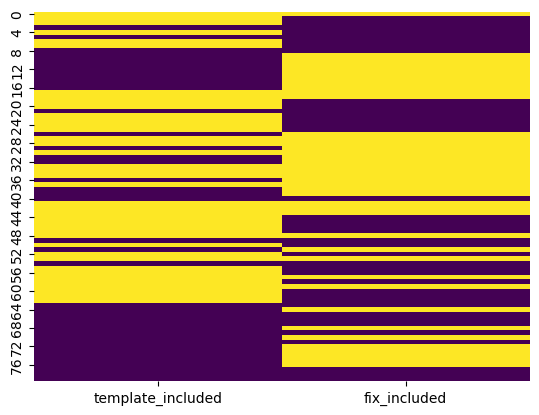

In [100]:
info['fix_included'] = [subject in fix_sample.subject.tolist() for subject in info.participant_id.tolist()]
info['fix_timepoint'] = None

for s,subject in enumerate(info.participant_id):
    if subject in fix_sample.subject.tolist():
        info.at[s,'fix_timepoint'] = fix_sample[fix_sample.subject==subject].session.values[0]

# Show the counterbalancing of the template and fix datasets
sb.heatmap(info[['template_included', 'fix_included']], cmap='viridis', cbar=False)

,participant_id,template_timepoint,fix_timepoint
0,sub-01,pre,pre
17,sub-18,post,post
18,sub-19,post,post
27,sub-28,pre,post
28,sub-29,post,post
30,sub-31,post,pre
33,sub-34,pre,pre
34,sub-35,post,pre
35,sub-36,pre,pre
37,sub-38,post,pre


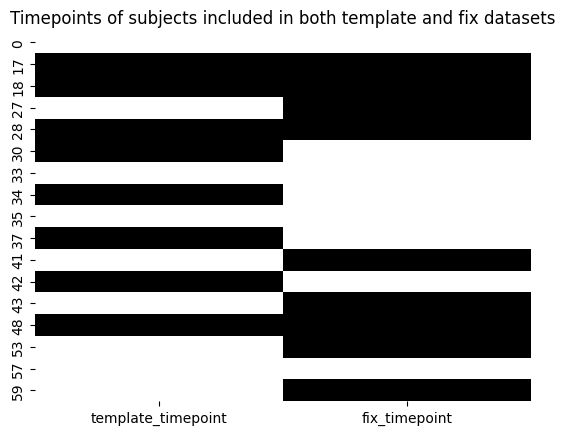

In [103]:
# Highlight matching timepoints of subjects that were included in both the template and fix training
matching_timepoints = info[info.template_included.values & info.fix_included.values][['participant_id', 'template_timepoint', 'fix_timepoint']]
mapping = {'pre': 0, 'post': 1}
sb.heatmap(matching_timepoints[['template_timepoint', 'fix_timepoint']].apply(lambda x: x.map(mapping)), cmap='binary', cbar=False)
plt.title('Timepoints of subjects included in both template and fix datasets')
matching_timepoints

In [130]:
n_fix_train = np.where(info.fix_included)[0].shape[0]
total = info.shape[0]*2-3 # 2 timepoints per subject, 1 subject is missing two timepoints (pre+post) and 1 subject is missing one timepoint (post)
print(f'Number of subjects included in the fix training dataset: {n_fix_train} ({n_fix_train/total*100:.2f}%)')
print(f'Number of subjects included in both fix and template datasets: {matching_timepoints.shape[0]}')
print(f'Number of subject and timepoints included in both: {(matching_timepoints.template_timepoint == matching_timepoints.fix_timepoint).sum()}')

Number of subjects included in the fix training dataset: 41 (26.11%)
Number of subjects included in both fix and template datasets: 17
Number of subject and timepoints included in both: 8


In [119]:
# Show fix_demographics of included and excluded subjects (count categorical
# values of

fix_demographics = info.groupby(['fix_included']).agg({'sex': pd.Series.value_counts,
                                               'age': ['mean', 'std'],
                                               'group': pd.Series.value_counts,
                                               'condition': pd.Series.value_counts,
                                               'fix_timepoint': pd.Series.value_counts})
fix_demographics = fix_demographics.reindex([True, False])
fix_demographics.to_latex(f'{base_dir}/results/fix_demographics.tex')
fix_demographics


sex        age                   group        condition  \
             value_counts       mean        std value_counts     value_counts   
fix_included                                                                    
True             [21, 20]  56.146341  11.731498     [21, 20]  [11, 11, 10, 9]   
False            [21, 18]  54.948718  10.280151     [20, 19]   [11, 10, 9, 9]   

             fix_timepoint  
              value_counts  
fix_included                
True              [22, 19]  
False                   []